Code wird auch regelmäßig bei https://github.com/EvanderCorvus/AgentSimulation updated.


In [442]:
import torch as tr
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

In [443]:
device = tr.device('cuda' if tr.cuda.is_available() else 'cpu')
# print(device)
tr.set_default_dtype(tr.float)
tr.set_default_device(device)

In [444]:
#hyperparameters
batch_size = 512
epoch = 50
t_update = 5
g = 0.9
max_steps = 40

In [445]:
def d(L,a=1):
    direction_mapping = [
        tr.tensor([0,1],dtype=tr.float).to(device), #up
        tr.tensor([0,-1],dtype=tr.float).to(device),#down
        tr.tensor([-1,0],dtype=tr.float).to(device), #left
        tr.tensor([1,0],dtype=tr.float).to(device) #right
    ]
    return tr.stack(direction_mapping).to(device)[L]*a
def U(U0,x,y):
    bool = (x**2+y**2)**0.5>0.5
    P = 16*U0*(x**2+y**2-0.25)**2
    P[bool] = 0
    return P
    
def force(x,y,type='mexican'):
    if type == 'lorenzian':
        if isinstance(x, tr.Tensor):
            f = tr.stack([-3/(1+4*y**2),tr.zeros(y.shape).to(device)],dim=1).to(device)
            return f
        else:
            U,V = -1/(1+4*y**2), np.zeros(y.shape)
            return U,V
    if type == 'mexican':
        
        if isinstance(x, tr.Tensor):
            r = tr.sqrt(x**2+y**2)
            bool = r>0.4
            U0 = 0.3
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            f = tr.stack([fr*x,fr*y],dim=1).to(device)
            return f
        else:
            r = np.sqrt(x**2+y**2)
            bool = r>0.5
            U0 = 0.3
            fr = -64*U0*(r**2-0.25)
            fr[bool] = 0
            U,V = fr*x,fr*y
            #U,V = x*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2)), y*U0/sigma**2*np.exp(-1/(2*sigma**2)*(x**2+y**2))
            return U,V
        




In [446]:
#Agent Class
class Agent(nn.Module):
    def __init__(self, x, y):#initialize agent at location (-0.5,-0.5) with bias 0
        super(Agent, self).__init__()
        self.x=x #x coordinate
        self.y=y #y coordinate
        self.input = nn.Linear(4, 64,dtype=tr.float) #input layer
        # self.hidden1 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden2 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden3 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden4 = nn.Linear(64, 64,dtype=tr.float) #hidden layer
        # self.hidden5 = nn.Linear(64, 32, dtype = tr.float) #hidden layer
        self.output = nn.Linear(64, 4,dtype=tr.float) #output layer
        self.activation = nn.LeakyReLU() #activation function
        self.dropout = nn.Dropout(p=0.2) #dropout layer

    def forward(self, x): #forward pass
        x1 = self.activation(self.input(x))
        x1 = self.dropout(x1)

        # x2 = self.activation(self.hidden1(x1))
        # x3 = self.activation(self.hidden2(x2))
        # x4 = self.activation(self.hidden3(x3))
        # x5 = self.activation(self.hidden4(x4))
        # x6 = self.activation(self.hidden5(x5))
        x7 = self.output(x1)
        return x7
    

    def move(self,Q,e): 

        L=tr.argmax(Q,dim=1)
        random_vector = tr.rand(L.shape,dtype=tr.float).to(device)
        bool_vector = random_vector<e
        #randomly choose action with probability e
        L[bool_vector] = tr.randint(0,4,(1,),dtype=tr.int64).to(device) 
        a = tr.tensor(0.0357,dtype=tr.float).to(device)
        dr = d(L,a) 
        dx = dr[:,0]
        dy = dr[:,1]

        self.x+=dx
        self.y+=dy

    def R(self,F,Q):
        # target = tr.cat([0.5*tr.ones(self.x.shape),tr.zeros(self.x.shape)]).to(device)
        
        dist = tr.stack([self.x-0.5,self.y],dim=1).to(device)
        dist_norm = tr.norm(dist,dim=1).to(device)
        
        di = d(tr.argmax(Q,dim=1))

        reshaped_di = di.unsqueeze(1).to(device)
        reshaped_force = F.unsqueeze(2).to(device)
        work = (reshaped_di@reshaped_force).view(batch_size,1).squeeze()

        return tr.tanh(work)-0.5*dist_norm**2

In [447]:
#Simulation Setup
def episode(agent,t_agent,t_update, max_steps,g,optimizer,e):
    
    X,Y = agent.x,agent.y
    for dT in range(max_steps):
        optimizer.zero_grad()#zero gradients

        if dT%t_update==0:#update target agent every 100 steps
            t_agent.load_state_dict(agent.state_dict())


        state = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q1 = agent.forward(state)
        agent.move(Q1,e)

        state2 = tr.stack([agent.x, agent.y, -tr.abs(agent.y), tr.zeros(agent.x.shape[0],dtype=tr.float).to(device)],dim=1) #state
        Q2 = t_agent.forward(state2)#.transpose(0,1)) #Q value of target agent
        
        F = force(agent.x,agent.y)

        maxQ1 = tr.max(Q1,dim=1)[0]
        maxQ2 = tr.max(Q2,dim=1)[0]

        #target Q value
        target = agent.R(F, Q1) + g*maxQ2 

        criterion = nn.MSELoss()
        loss = criterion(target,maxQ1) #loss

        #backpropagate
        loss.backward()

        #update weights                         
        optimizer.step()   

        #save data to track agent                    
        newX = X.reshape(batch_size,-1)
        newY = Y.reshape(batch_size,-1)
        newx = agent.x[:,None]
        newy = agent.y[:,None]
       
        X = tr.cat((newX,newx),dim=1)
        Y = tr.cat((newY,newy),dim=1)

    
    return X,Y



9
19
29
39
49


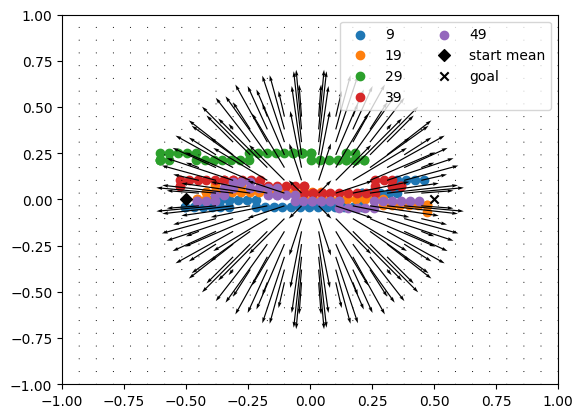

In [448]:
#Simulation
mu, sig = -0.5, 0.1
x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
agent = Agent(x,y).to(device)

t_agent = Agent(x,y).to(device)
t_agent.load_state_dict(agent.state_dict()) #copies weights from agent to t_agent
t_agent.eval()


optimizer = tr.optim.Adam(agent.parameters(), lr=0.001)

for i in range(epoch):
    e = 0.3
    X,Y = episode(agent, t_agent, t_update = t_update, max_steps = max_steps, g=g, optimizer=optimizer,e=e)
    agent.x = tr.randn(batch_size, dtype=tr.float).to(device)*sig + mu
    agent.y = tr.randn(batch_size, dtype=tr.float).to(device)*sig
    
    
    if i%10 == 9:
        x,y = X[0].detach().to('cpu').numpy(),Y[0].detach().to('cpu').numpy()
        plt.scatter(x,y,label=int(i))#,c=np.arange(len(x)),cmap='viridis')
        print(i)

X1,Y1 = np.meshgrid(np.linspace(-1,1,30),np.linspace(-1,1,30))  
U,V = force(X1,Y1)
plt.quiver(X1,Y1,U,V)


plt.xlim(-1,1)
plt.ylim(-1,1)
plt.scatter(-0.5,0,c='black',label='start mean',marker='D')    
plt.scatter(0.5,0,c='black',label='goal',marker='x')
plt.legend(ncol=2,loc='upper right')
plt.show()


In [449]:
# from matplotlib.colors import Normalize
# X1,Y1 = np.meshgrid(np.linspace(-1,1,34),np.linspace(-1,1,40))  
# Z = U(0.3,X1,Y1)
# #Set up the colormap with transparency based on potential values
# alpha = Normalize(vmin=Z.min(), vmax=Z.max())
# cmap = plt.cm.viridis
# colors = cmap(alpha(Z))


# plt.contourf(X1,Y1,Z,cmap='viridis')
# plt.colorbar()
# plt.show()
# plt.quiver(X1,Y1,U,V)
# plt.xlim(-1,1)
# plt.ylim(-1,1)
# plt.scatter(-0.5,0,c='black',label='start mean',marker='D')    
# plt.scatter(0.5,0,c='black',label='goal',marker='x')
# plt.legend(ncol=2,loc='upper right')
# plt.show()